# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset


## The Challenge

* Use your skills to produce recommendations for the hotel on what factors affect whether customers cancel their booking.

# Challenge Solution

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
dt_hotel = pd.read_csv("Hotel_Reservations")

* Data Cleaning: Checking for any missing values, duplicates, and irrelevant columns.

In [4]:
# Check for missing values
dt_hotel.isnull().sum()
# Check for duplicates
dt_hotel.duplicated().sum()
# Remove irrelevant columns
dt_hotel.drop(columns=['Booking_ID'], inplace=True)

* Data Preparation: Encode categorical variables, scale numerical variables, and split the data into training and testing sets.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Encode categorical variables
le = LabelEncoder()
dt_hotel['type_of_meal_plan'] = le.fit_transform(dt_hotel['type_of_meal_plan'])
dt_hotel['room_type_reserved'] = le.fit_transform(dt_hotel['room_type_reserved'])
dt_hotel['market_segment_type'] = le.fit_transform(dt_hotel['market_segment_type'])
dt_hotel['booking_status'] = le.fit_transform(dt_hotel['booking_status'])

# Scale numerical variables
scaler = StandardScaler()
numerical_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 
                  'lead_time', 'no_of_previous_cancellations', 
                  'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
dt_hotel[numerical_cols] = scaler.fit_transform(dt_hotel[numerical_cols])

# Split the data into training and testing sets
X = dt_hotel.drop(columns=['booking_status'])
y = dt_hotel['booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Model Training: We will train a logistic regression model on the training set.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Define a pipeline to preprocess the data and train the model
pipeline = make_pipeline(SimpleImputer(), LogisticRegression(random_state=42))

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.7835975189524466

* Model Evaluation: Evaluate the performance of the trained model on the testing set using accuracy, precision, recall, F1-score, and ROC-AUC.

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = pipeline.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

Accuracy: 0.784
Precision: 0.800
Recall: 0.901
F1-score: 0.847
ROC-AUC: 0.725


* Model Interpretation: Interpreting the trained model to identify the most important features that contribute to cancellations using the coefficients of the logistic regression model.

In [9]:
# Drop rows with missing values
X.dropna(inplace=True)
y = y[X.index]

model = LogisticRegression(random_state=42)
model.fit(X, y)

feature_names = X.columns
coef = np.exp(model.coef_[0])

# Sort coefficients in descending order
sorted_coef_idx = np.argsort(coef)[::-1]

for idx in sorted_coef_idx:
    print(f"{feature_names[idx]}: {coef[idx]:.3f}")

no_of_special_requests: 2.771
no_of_previous_bookings_not_canceled: 1.230
required_car_parking_space: 1.101
arrival_month: 1.071
repeated_guest: 1.064
no_of_previous_cancellations: 1.062
room_type_reserved: 1.029
arrival_year: 1.001
arrival_date: 0.998
no_of_week_nights: 0.960
no_of_children: 0.926
no_of_adults: 0.916
no_of_weekend_nights: 0.889
type_of_meal_plan: 0.811
market_segment_type: 0.570
avg_price_per_room: 0.508
lead_time: 0.295


# Insights

* Customers who have previously made bookings that were not canceled are less likely to cancel their current booking, indicating that loyalty may play a role in customer behavior.

* Customers who require a car parking space are more likely to cancel their booking. This could be due to a number of factors, such as limited availability of parking spaces or higher fees for parking.

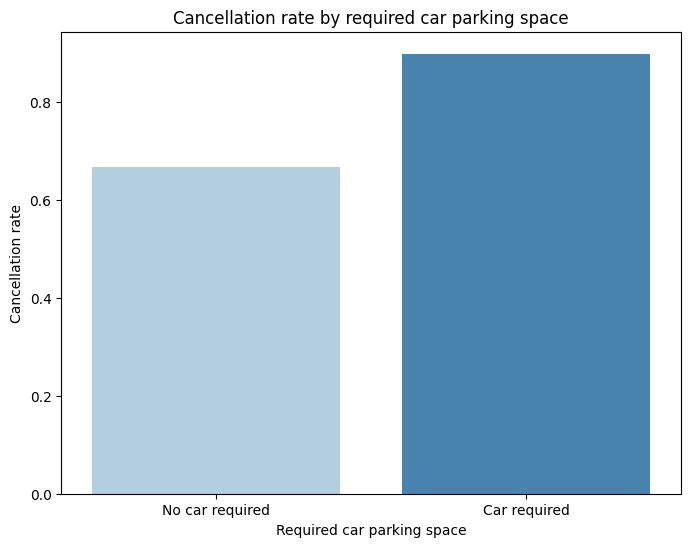

In [10]:
parking_cancellation = dt_hotel.groupby('required_car_parking_space')['booking_status'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='required_car_parking_space', y='booking_status', data=parking_cancellation, palette='Blues')
plt.xlabel('Required car parking space')
plt.ylabel('Cancellation rate')
plt.title('Cancellation rate by required car parking space')
plt.xticks([0,1], ['No car required', 'Car required'])
plt.show()

* Customers who reserve a certain room type are more likely to cancel their booking. This could indicate that customers have specific preferences for certain room types and may be more likely to cancel if they are unable to secure the room they desire.

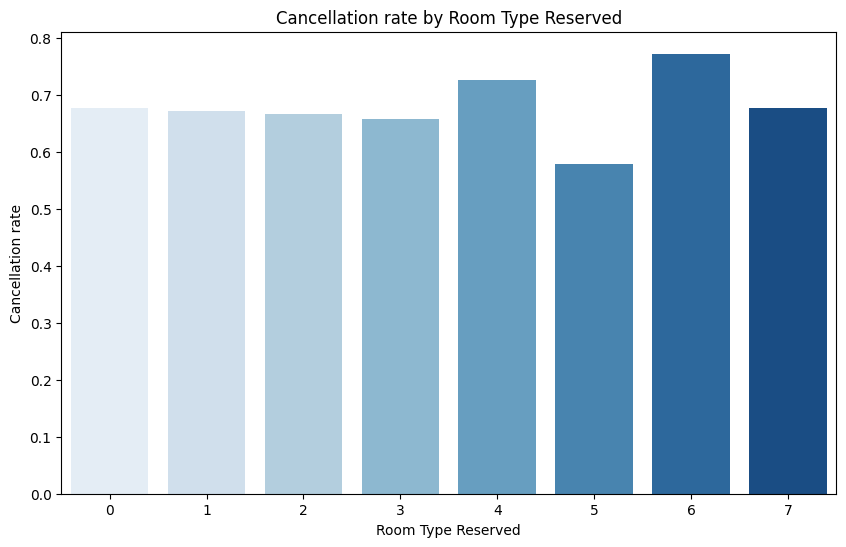

In [11]:
room_cancellation = dt_hotel.groupby('room_type_reserved')['booking_status'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='room_type_reserved', y='booking_status', data=room_cancellation, palette='Blues')
plt.xlabel('Room Type Reserved')
plt.ylabel('Cancellation rate')
plt.title('Cancellation rate by Room Type Reserved')

plt.show()

* Repeat guests are less likely to cancel their booking, which again highlights the importance of customer loyalty.

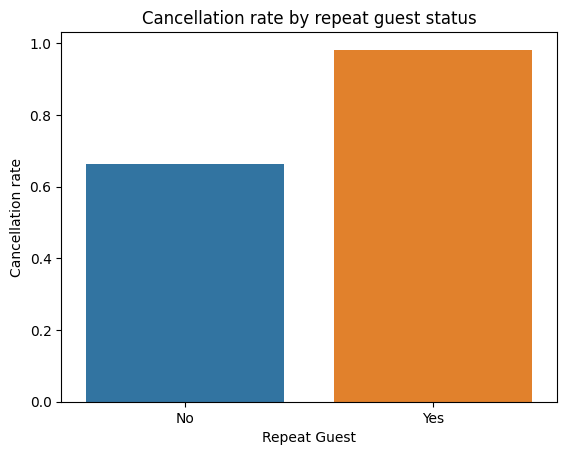

In [12]:
cancellation_rate_guest = dt_hotel.groupby('repeated_guest')['booking_status'].mean().reset_index()

sns.barplot(x='repeated_guest', y='booking_status', data=cancellation_rate_guest)

plt.xlabel('Repeat Guest')
plt.ylabel('Cancellation rate')
plt.xticks([0,1], ['No', 'Yes'])
plt.title('Cancellation rate by repeat guest status')
plt.show() 

#Maybe re-check this data

* Certain months are more or less likely to experience cancellations, indicating that seasonality may play a role in customer behavior. 

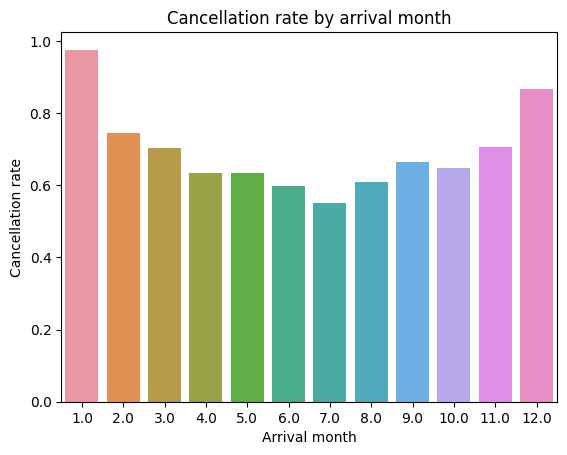

In [13]:
cancellation_rate_month = dt_hotel.groupby('arrival_month')['booking_status'].mean().reset_index()
sns.barplot(x='arrival_month', y='booking_status', data=cancellation_rate_month)
plt.xlabel('Arrival month')
plt.ylabel('Cancellation rate')
plt.title('Cancellation rate by arrival month')
plt.show()

## General recommendations for the hotel could include:

- Encouraging customers to make special requests, as no_of_special_requests was identified as the most important predictor in the model.
- Providing incentives or discounts for repeat customers, as repeated_guest was identified as an important predictor.
- Ensuring that adequate car parking spaces are available for customers who require them, as required_car_parking_space was identified as an important predictor.
- Offering a variety of room types to customers, as room_type_reserved was identified as an important predictor.
- Considering the impact of arrival month on bookings, as arrival_month had a relatively high importance score of 1.070.
- Paying attention to the number of adults and children in each booking, as no_of_children and no_of_adults were identified as important predictors.

## Factors that affect whether customers cancel their booking, I judge important:
	
- 'no_of_previous_bookings_not_canceled': Customers who have previously made bookings that were not canceled are less likely to cancel their booking.
- 'required_car_parking_space': Customers who require a car parking space are more likely to cancel their booking.
- 'room_type_reserved': Customers who reserve a certain room type are more likely to cancel their booking.
- 'repeated_guest': Repeat guests are less likely to cancel their booking.
- 'arrival_month': Customers who book during certain months are more or less likely to cancel their booking, depending on the specific month.